In [2]:
import numpy as np
import pandas as pd
import rebound
import reboundx
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
Degree_To_Rad = np.pi/180.
AU_To_Meter = 1.496e11
yr = 365*24*3600 # s
G = 6.6743e-11 # SI units
c_light = 3e8


m_Sun = 1.99e30 # solar mass in [kg]
R_Sun = 6.957e8 # solar radius in [m]
m_J = 1.898e27 # Jupiter mass in [kg]
R_J = 7.1492e7 # Jupiter radius in [m]
a_J = 7.78479e8 # Jupiter semi-major axis in [m]
m_E = 5.9722e24 # Earth mass in [kg]
R_E = 6.371e6 # Earth radius in [m]


k1 = 1.0 # m_star/m_Sun
m_Star = k1 * m_Sun
R_Star = k1 * R_Sun
R_sub = (k1**2) * 4 * R_Sun

k2 = 1.0 # m_planet/m_Jupiter
m_Planet = k2 * m_J

if k2 <= 0.41:
    R_Planet = R_E * (m_Planet/m_E)**(0.59) # low-mass planet; scale with Earth
else:
    R_Planet = R_J * k2**(-0.04) # massive planet; scale with Jupiter

k_ap = 10
a_Planet = k_ap * R_Sun



In [4]:
beta = 0.01

a1 = a_Planet
alpha = a1/a2
c = 0.428
mu1 = m_Planet/(m_Star/(1-beta))
mu2 = 1e-20 * m_Planet/m_Star # massless test particle
tau_e2 = 2*a2**2*c_light/(5*G*m_Star*beta)
tau_n2 = 5/6 * tau_e2

n1 = np.sqrt(G*m_Star/(a1**3))
a2_res = a1 * (2**(2/3)) * ((1-beta)**(1/3))
n2_res = n1/2 # np.sqrt(G*m_Star*(1-beta)/(a2_res**3))


ODE - 1st order
--

$R_2 = \mu_1a_2^2n_2^2C_1e_2\cos{\phi_2}$

$\frac{d n_2}{dt} = 6 \mu_1 {n_2}^2 C_1e_2\sin{\phi_2} + \frac{n_2}{\tau_{n_2}}(1+3e_2^2)$

$\frac{d e_2}{dt} = -\mu_1n_2C_1\sin{\phi_2} - \frac{e_2}{\tau_{e_2}}$

$\frac{d\phi_2}{dt} = 2n_2 - n_1 - \frac{\mu_1 n_2}{e_2}C_1\cos{\phi_2}$


In [5]:
def ode(t, R):
    n2, e2, phi2 = R
        
    dn2dt = 6*mu1*(n2_res**2)*c*e2*np.sin(phi2) + n2_res/tau_n2*(1+3*e2**2)
    
    de2dt = -mu1*n2_res*c*np.sin(phi2) - e2/tau_e2
    
    dphi2dt = 2*n2 - n1 - mu1*n2_res*c*np.cos(phi2)/e2
        
    dRdt=[dn2dt, de2dt, dphi2dt]
    
    return dRdt


# def ode(t, R):
#     n2, e2, phi2 = R
        
#     dn2dt = 6*mu1*(n2**2)*c*e2*np.sin(phi2) + n2/tau_n2*(1+3*e2**2)
    
#     de2dt = -mu1*n2*c*np.sin(phi2) - e2/tau_e2
    
#     dphi2dt = 2*n2 - n1 - mu1*n2*c*np.cos(phi2)/e2
        
#     dRdt=[dn2dt, de2dt, dphi2dt]
    
#     return dRdt 
    

In [6]:
n2_initial = n2_res # np.sqrt(G*m_Star*(1-beta)/(a2**3))
e2_initial = 1e-3 #c*mu1*0.5*n1_initial/np.abs(2*n2_initial-n1_initial)
phi2_initial = np.pi

R0=[n2_initial, e2_initial, phi2_initial]

t_span = (0., 2000*yr)
sol = solve_ivp(ode, t_span, R0)# dense_output=True, rtol=1.e-8,atol=1.e-8)


In [7]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.685e+00 ...  6.307e+10  6.307e+10]
        y: [[ 9.930e-06  9.930e-06 ...  1.006e-05  9.960e-06]
            [ 1.000e-03  1.000e-03 ...  6.973e-01  6.997e-01]
            [ 3.142e+00  3.142e+00 ...  3.880e+00  4.015e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 202094
     njev: 0
      nlu: 0

In [8]:
t_sol, n2_sol, e2_sol, phi2_sol = sol.t, sol.y[0], sol.y[1], sol.y[2]

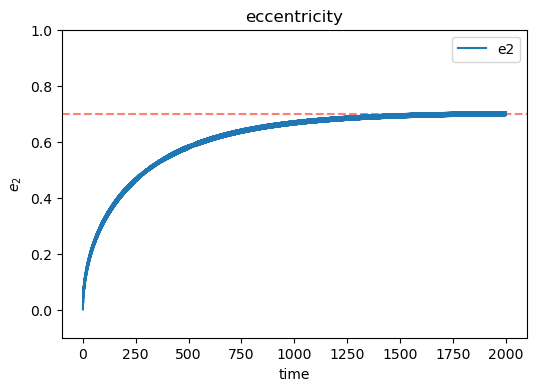

In [8]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
# ax.set_xlim([-0.1,1.])
ax.set_ylim([-0.1,1.])
plt.title("eccentricity")
plt.xlabel("time")
plt.ylabel(r"$e_2$")
plt.axhline(y=0.7, color='salmon', linestyle='--')
plt.plot(t_sol/yr, e2_sol, label='e2')
plt.legend()
plt.show()

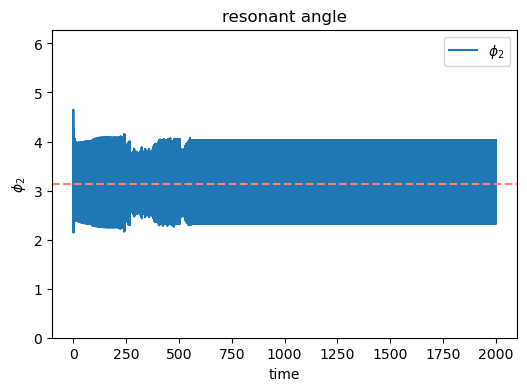

In [9]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
# ax.set_xlim([-2.5,1.5])
ax.set_ylim([0,6.28])
plt.title("resonant angle")
plt.xlabel("time")
plt.ylabel(r'$\phi_2$')
plt.plot(t_sol/yr, phi2_sol%(2*np.pi), label=r'$\phi_2$')
plt.axhline(y=np.pi, color='salmon', linestyle='--')
plt.legend()
plt.show()

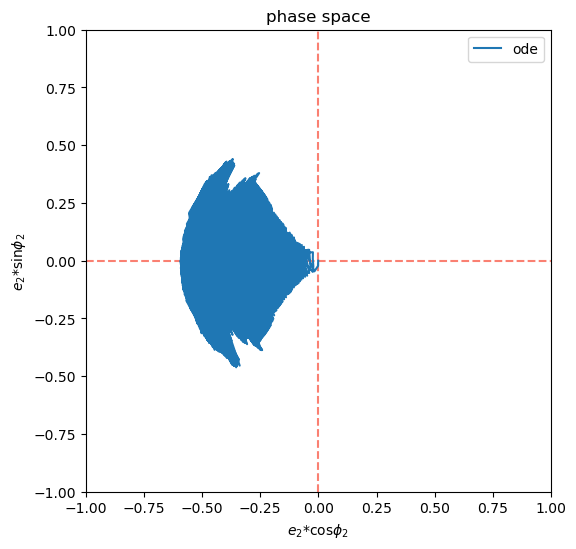

In [10]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.set_xlim([-1., 1.])
ax.set_ylim([-1., 1.])
plt.title("phase space")
plt.xlabel(r"$e_2$*cos$\phi_2$")
plt.ylabel(r"$e_2$*sin$\phi_2$")
plt.axvline(x=0, color='salmon', linestyle='--')
plt.axhline(y=0, color='salmon', linestyle='--')
plt.plot(e2_sol[0:5000]*np.cos(phi2_sol[0:5000]), e2_sol[0:5000]*np.sin(phi2_sol[0:5000]), label='ode')
plt.legend()
plt.show()